In [1]:
import os
import time
import shutil
import requests
import zipfile

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms

## 1. Data

### 1.1. Downloading

First we need to download and unzip the Fashion MNSIT dataset from Dropbox. It contains 70,000 28x28 pixel images of 10 different classes of fashion items (e.g. coats, shirts, shoes). They've already been split into training (60,000 images) and testing (10,000 images) sets.

In [2]:
DATA_URL = 'https://www.dropbox.com/s/rpilbej8wg5iyn0/fashionmnist.zip?dl=1'
SAVE_PATH = 'fashionmnist'

if not os.path.exists(SAVE_PATH):
    # Download the data zip file.
    response = requests.get(DATA_URL, stream=True)
    zip_path = SAVE_PATH + '.zip'
    with open(zip_path, 'wb') as f:
        shutil.copyfileobj(response.raw, f)
    # Unzip the file.
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(SAVE_PATH)
    # Delete the zip file.
    os.remove(zip_path)

### 1.2.  `Datasets` and `Dataloader`s

In PyTorch, you'll usually create or import a `Dataset` subclass to represent your data. Once you've done that, you can use it to instantiate a `Dataloader` object which allows you to easily iterate over your training set in `BATCH_SIZE` chunks.

In [3]:
IMAGE_SIZE = 28
NUM_CLASSES = 10
NUM_CHANNELS = 1
BATCH_SIZE = 64
ID_TO_LABEL = {
    0 :'T-shirt/top',
    1 :'Trouser',
    2 :'Pullover',
    3 :'Dress',
    4 :'Coat',
    5 :'Sandal',
    6 :'Shirt',
    7 :'Sneaker',
    8 :'Bag',
    9 :'Ankle boot'}


class FashionDataset(Dataset):

    def __init__(self, path, 
                 image_size, num_channels, image_transform=None):
        self.num_channels = num_channels
        self.image_size = image_size
        self.image_transform = image_transform
        data_df = pd.read_csv(path)
        self.X = data_df.values[:, 1:]
        self.X = self.X.reshape(-1, image_size, image_size, num_channels)
        self.X = self.X.astype('float32')
        self.y = data_df.values[:, 0]
        
    def __getitem__(self, index):
        batch_X, batch_y = self.X[index], self.y[index]
        if self.image_transform is not None:
            batch_X = self.image_transform(batch_X)
        return batch_X, batch_y

    def __len__(self):
        return len(self.X)

# This simple transform coverts the image from an numpy array
# to a PyTorch tensor and remaps its values from 0-255 to 0-1. 
# Many other types of transformations are available, and they 
# can easily be composed into a pipeline. For more info see: 
# https://pytorch.org/docs/stable/torchvision/transforms.html
image_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = FashionDataset(
    'fashionmnist/fashion-mnist_train.csv', 
    IMAGE_SIZE, 
    NUM_CHANNELS, 
    image_transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True)

val_dataset = FashionDataset(
    'fashionmnist/fashion-mnist_test.csv', 
    IMAGE_SIZE, 
    NUM_CHANNELS, 
    image_transform)

val_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE)

### 1.3. Show some examples from the training set

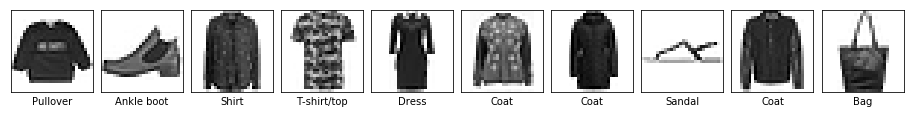

In [4]:
def plot_images(data, labels, image_size):
    size = 28
    fig, axes = plt.subplots(
        1, data.shape[0], figsize=(16, 4), 
        subplot_kw={'xticks':[], 'yticks':[]},
        gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(image_size, image_size), cmap='binary')
        ax.set_xlabel(labels[i])
        
images = train_dataset.X[:10]
class_ids = train_dataset.y[:10]
class_labels = [ID_TO_LABEL[class_id] for class_id in class_ids]
plot_images(images, class_labels, IMAGE_SIZE)

## 2. Modeling

The model below uses a single convolution with only 4 filters. Because of the simplicity of our dataset, it still manages to achieve nearly 90% accuracy after only 5 epochs and a minute or two of training.

Complete `FashionModel` by writing the `forward()` function. The layers you need have already been created for you; you just need to pass the input through them and return it. (Hint: You'll need to reshape the output from the convolutional layer.) Once you've got the model up and running, try to see if you can increase the accuracy on the validation set to above 95%.

Things you might try:

* Increasing the number of filters per convolution.
* Adding more convolutions.
* Adding a `BatchNorm2d` layer after `Conv2d`.
* Increasing the number of epochs.
* Changing the kernel size.
* Using different types of pooling or using stride > 1 in convolutional layers instead of pooling.

You might also find the [PyTorch API reference](https://pytorch.org/docs/stable/nn.html) useful.

In [6]:
class FashionModel(nn.Module):
    
    def __init__(self, num_channels, num_classes):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv_2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv_3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.linear = nn.Linear(3 * 3 * 64, num_classes)
        
    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear(x)
        return x


# Instantiate the model.    
model = FashionModel(NUM_CHANNELS, NUM_CLASSES)

# Send the model's tensors to the GPU if available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)    

## 3. Training

In [7]:
NUM_EPOCHS = 10
LOG_FREQ = 100
CHECKPOINT_PATH = 'checkpoint.pickle'


optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()  # Switch to training mode.
    print(f'Starting epoch {epoch}.')
    epoch_start_time = time.time()
    running_loss = 0.0
    running_accuracy = 0.0
    for batch_id, (batch_X, batch_y) in enumerate(train_dataloader):
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        output = model(batch_X)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Periodically print the loss and prediction accuracy.
        running_loss += loss.item()
        y_pred = output.argmax(dim=-1)
        running_accuracy += accuracy_score(batch_y, y_pred)
        if batch_id % LOG_FREQ == LOG_FREQ - 1:
            average_loss = running_loss / LOG_FREQ
            average_accuracy = running_accuracy / LOG_FREQ
            print(f'Mini-batch: {batch_id + 1}/{len(train_dataloader)} '
                  f'Loss: {average_loss:.5f} Accuracy: {average_accuracy:.5f}')
            running_loss = 0.0
            running_accuracy = 0.0
            
    # Log elapsed_time for the epoch.            
    elapsed_time = time.time() - epoch_start_time
    print(f'\nEpoch {epoch} completed in {elapsed_time // 60:.0f} minutes '
          f'{elapsed_time % 60:.0f} seconds.')
    
    # Calculate and log loss on validation set.
    with torch.no_grad():
        model.eval()
        running_loss = 0.0
        running_accuracy = 0.0
        for batch_id, (batch_X, batch_y) in enumerate(val_dataloader):
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            output = model(batch_X)
            loss = criterion(output, batch_y)
            running_loss += loss.item()
            y_pred = output.argmax(dim=-1)  
            running_accuracy += accuracy_score(batch_y, y_pred)
        average_loss = running_loss / len(val_dataloader)
        average_accuracy = running_accuracy / len(val_dataloader)
        print(f'Val Loss: {average_loss:.5f} Val Accuracy: {average_accuracy:.5f}\n')

Starting epoch 1.
Mini-batch: 100/938 Loss: 0.88341 Accuracy: 0.72750
Mini-batch: 200/938 Loss: 0.50730 Accuracy: 0.81484
Mini-batch: 300/938 Loss: 0.42053 Accuracy: 0.84906
Mini-batch: 400/938 Loss: 0.38884 Accuracy: 0.85766
Mini-batch: 500/938 Loss: 0.36094 Accuracy: 0.87266
Mini-batch: 600/938 Loss: 0.33046 Accuracy: 0.88375
Mini-batch: 700/938 Loss: 0.33469 Accuracy: 0.88000
Mini-batch: 800/938 Loss: 0.31148 Accuracy: 0.88750
Mini-batch: 900/938 Loss: 0.30392 Accuracy: 0.89094

Epoch 1 completed in 1 minutes 26 seconds.
Val Loss: 0.31192 Val Accuracy: 0.88246

Starting epoch 2.
Mini-batch: 100/938 Loss: 0.28404 Accuracy: 0.90078
Mini-batch: 200/938 Loss: 0.29870 Accuracy: 0.89172
Mini-batch: 300/938 Loss: 0.27401 Accuracy: 0.90203
Mini-batch: 400/938 Loss: 0.26421 Accuracy: 0.90109
Mini-batch: 500/938 Loss: 0.27053 Accuracy: 0.90094
Mini-batch: 600/938 Loss: 0.27270 Accuracy: 0.90141
Mini-batch: 700/938 Loss: 0.27998 Accuracy: 0.89969
Mini-batch: 800/938 Loss: 0.26518 Accuracy: 0.9